In [1]:
import sys
import os
import struct
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from utils import plot_utils
plot_utils.set_plotting_defaults()

In [3]:
subject = 1
volume_space=True
# fitting_type = 'bdcn_pca_fused'
fitting_type = 'sketch_tokens'

root = os.path.dirname(os.path.dirname(os.getcwd()))
out, fig_save_folder = plot_utils.load_fit_results(subject, volume_space, fitting_type, n_from_end=0, root=root, verbose=True);
plot_utils.print_output_summary(out)

if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01/sketch_tokens/Sep-16-2021_1118_19/all_fit_params

dict_keys(['voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'aperture', 'aperture_rf_range', 'models', 'n_prf_sd_out', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'shuff_rnd_seed', 'pc', 'min_pct_var', 'max_pc_to_retain', 'mult_patch_by_prf', 'map_resolution', 'do_avg_pool'])
voxel_mask: shape (699192,)
brain_nii_shape: shape (3,)
image_order: shape (7500,)
voxel_index: len 1
voxel_roi: len 2
voxel_ncsnr: shape (699192,)
aperture = 1.0
aperture_rf_range = 1.1
models: shape (875, 3)
n_prf_sd_out = 2
best_losses: shape (14913, 1)
best_lambdas: shape (14913, 1)
best_params: len 6
lambdas: shape (9,)
val_cc: shape (14913, 1)
val_r2: shape (14913, 1)
partial_masks: shape (1, 151)
partial_version_names: len 1
zscore_feature

In [5]:
out['val_cc']

array([[-0.04049705],
       [-0.04112642],
       [-0.02599401],
       ...,
       [ 0.        ],
       [ 0.02340431],
       [-0.04077868]], dtype=float32)

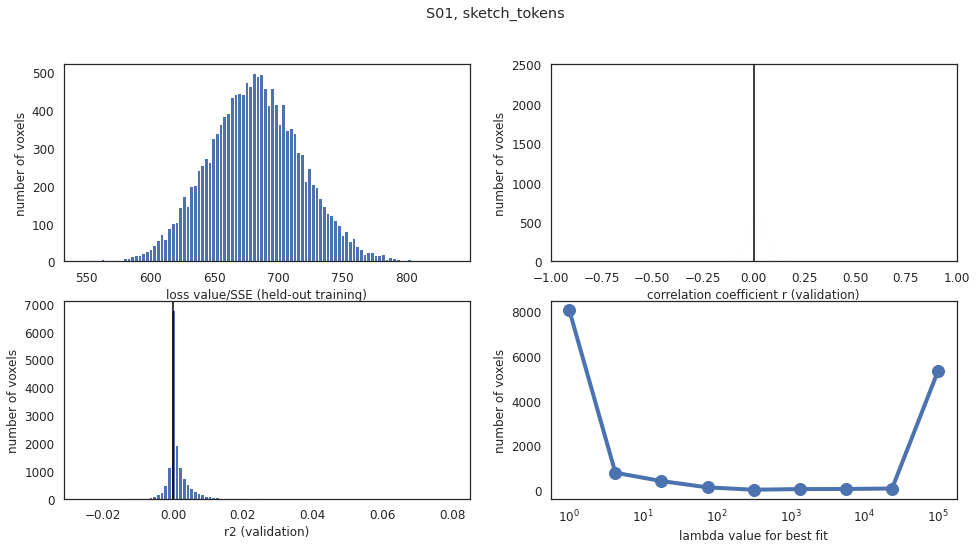

In [4]:
plot_utils.plot_perf_summary(subject, fitting_type, out, fig_save_folder=fig_save_folder)

In [9]:
# plot_utils.plot_fit_summary_volume_space(subject, fitting_type,out, fig_save_folder)

In [15]:
plot_utils.plot_summary_pycortex(subject, fitting_type, out, port=44447)

navigate browser to: 127.0.0.1:44447
Started server on port 44447
Stopping server


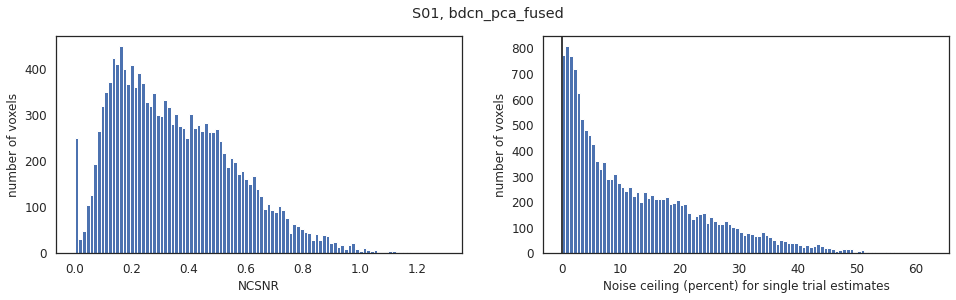

In [8]:
plot_utils.plot_noise_ceilings(subject, fitting_type,out, fig_save_folder)

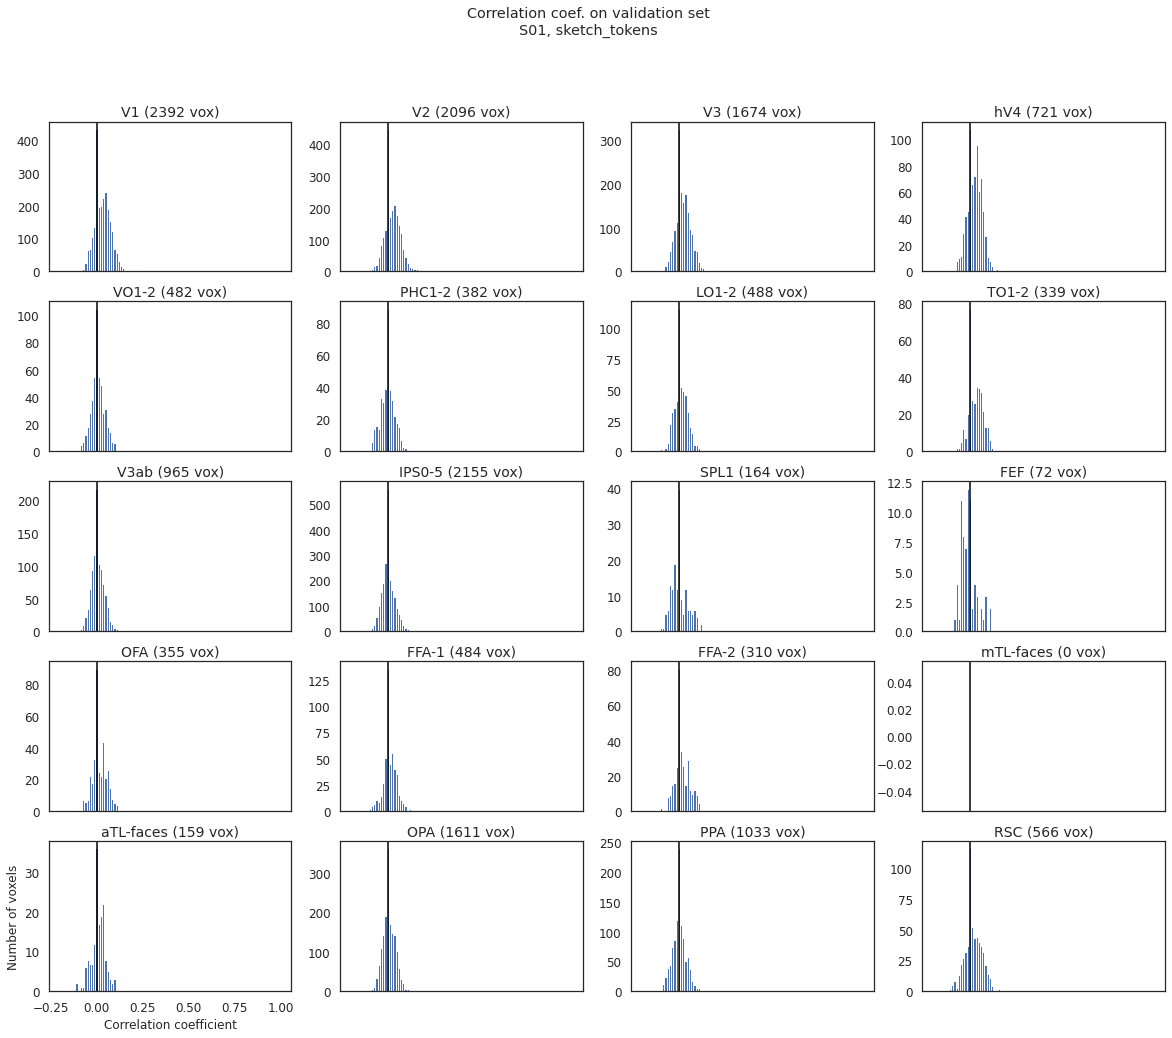

In [6]:
plot_utils.plot_cc_each_roi(subject, fitting_type,out, fig_save_folder)

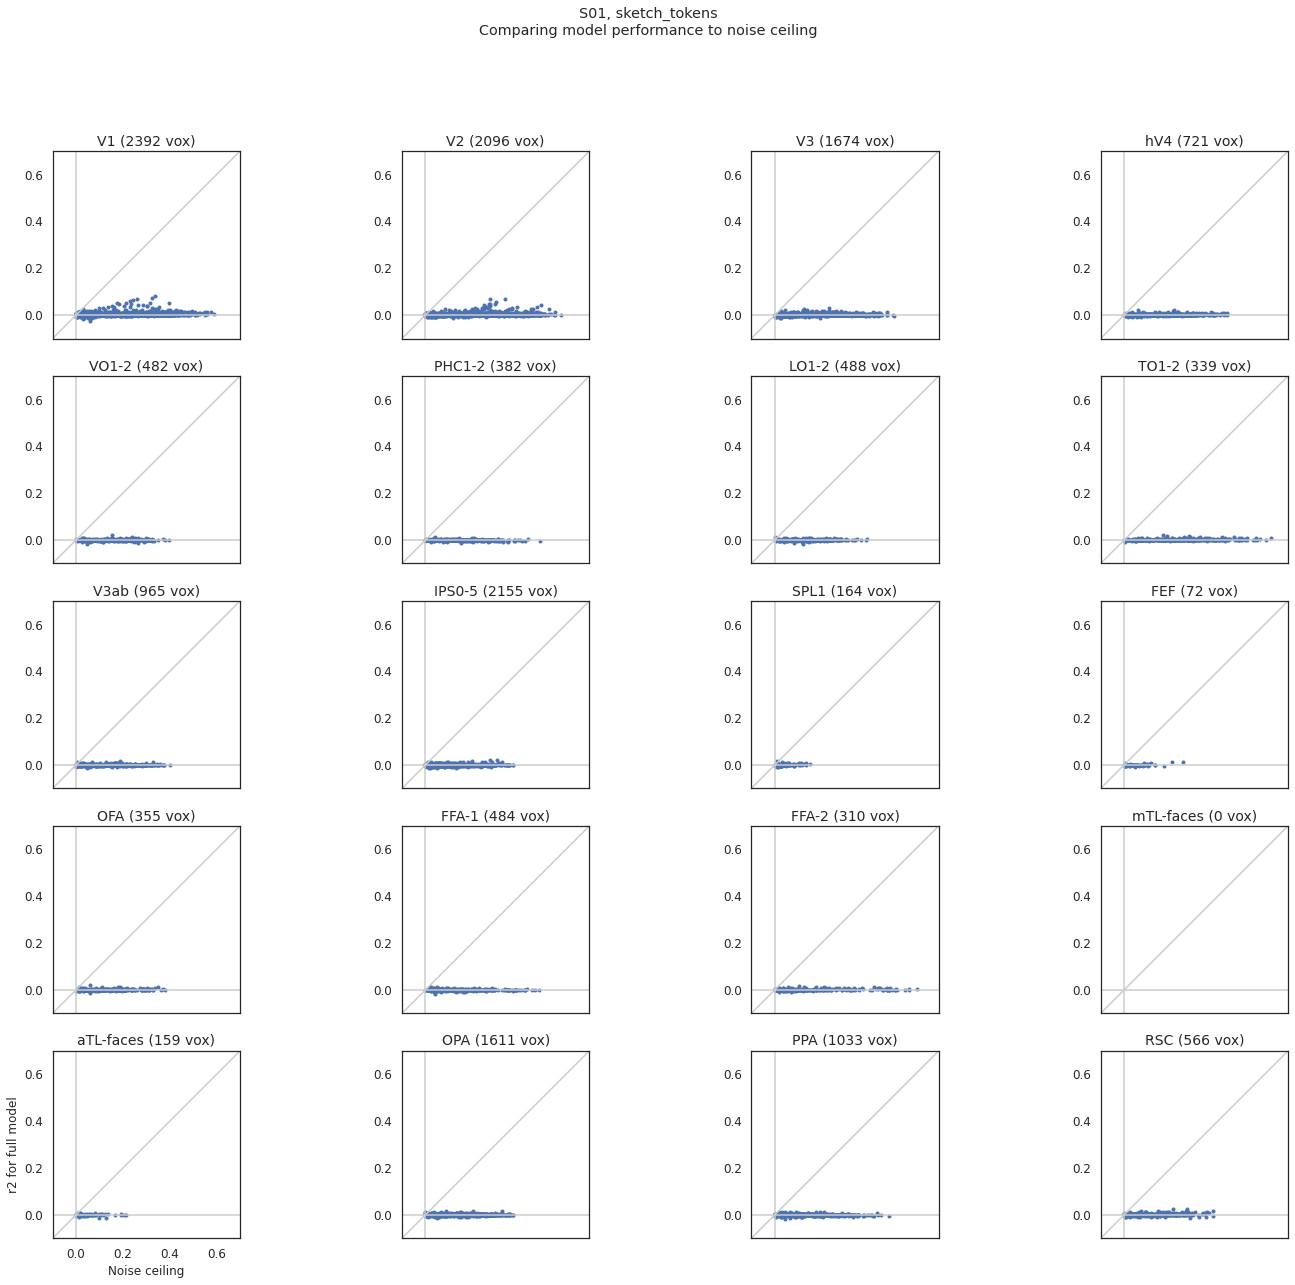

In [7]:
plot_utils.plot_r2_vs_nc(subject, fitting_type,out, fig_save_folder)

In [14]:
# plot_utils.plot_spatial_rf_circles(subject, fitting_type,out, cc_cutoff = 0.20, fig_save_folder=fig_save_folder)

Stopping server


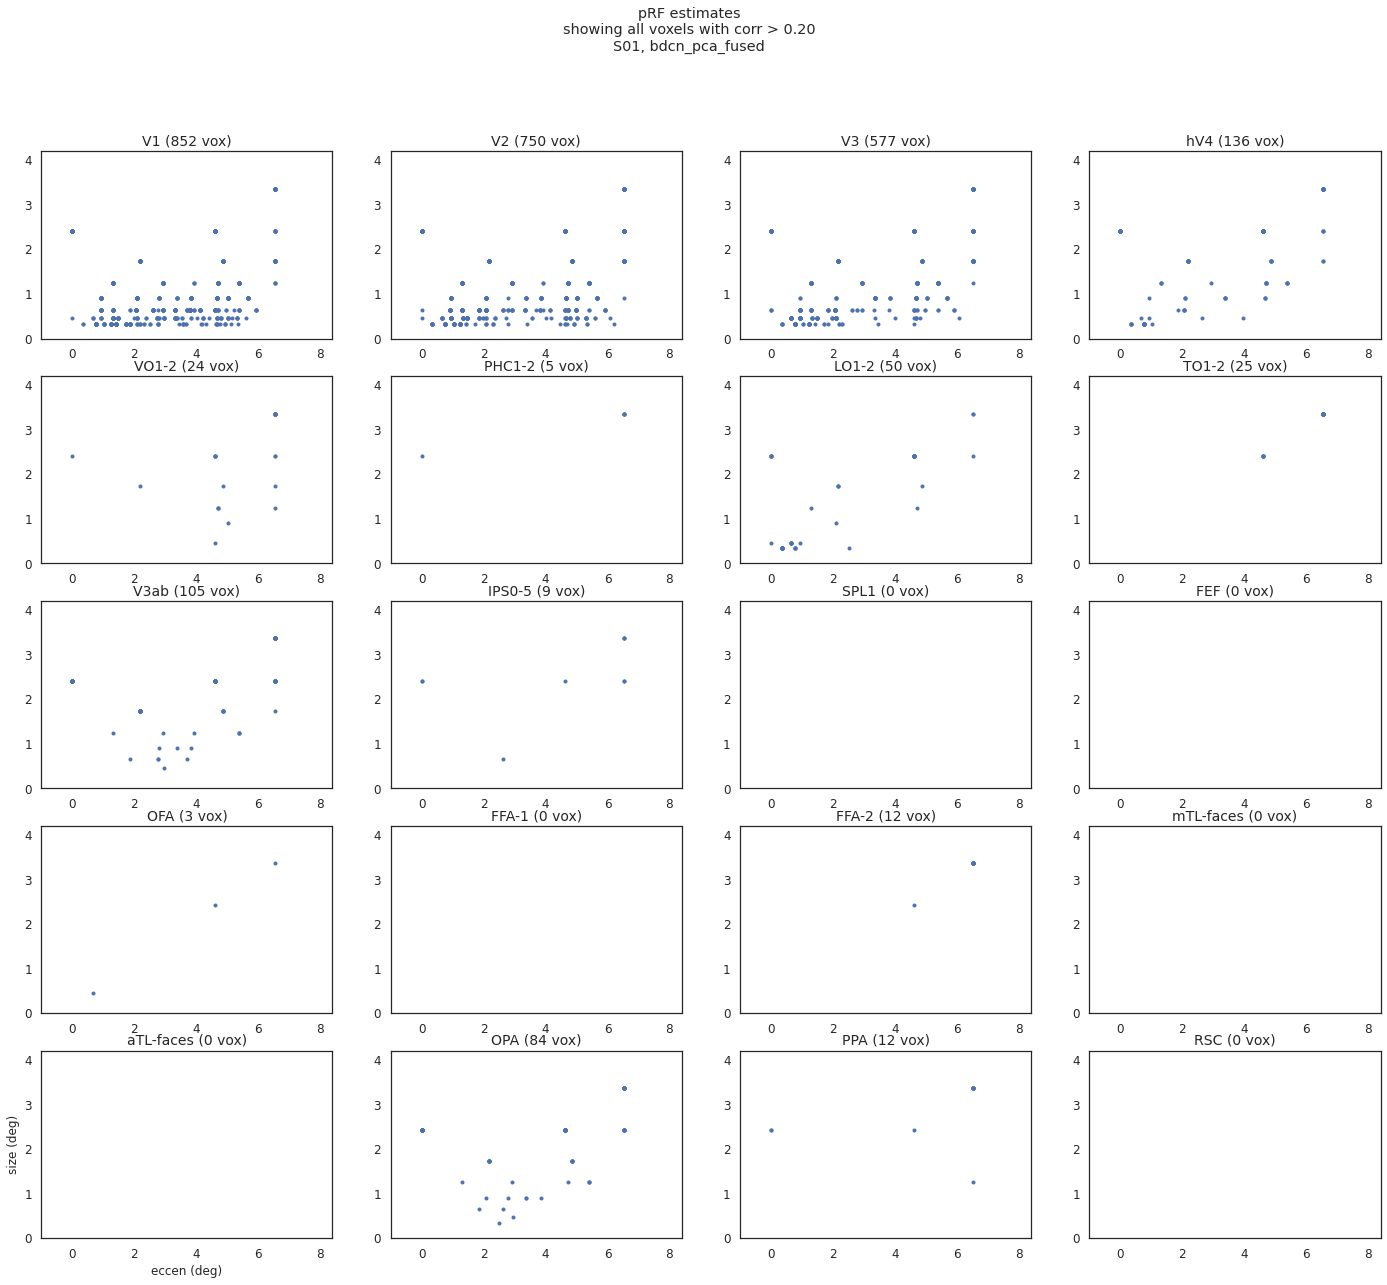

In [4]:
plot_utils.plot_size_vs_eccen(subject, fitting_type, out, cc_cutoff=0.2, fig_save_folder=fig_save_folder)

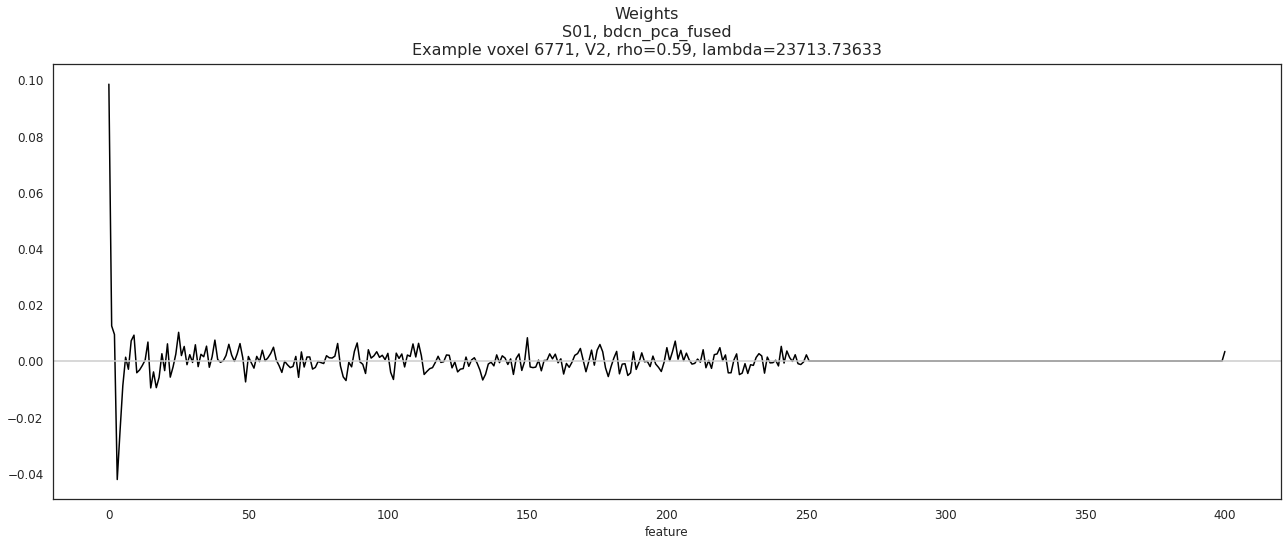

In [23]:
# Plotting some example weights...

from copy import deepcopy
roi_labels_retino, roi_labels_categ, ret_group_inds, categ_group_inds, ret_group_names, categ_group_names, \
        n_rois_ret, n_rois_categ, n_rois = plot_utils.get_roi_info(subject, out)

pp=0
val_cc = out['val_cc'][:,0]
lambdas = out['lambdas']
best_lambdas = out['best_lambdas']
vox2plot = np.argsort(np.nan_to_num(val_cc))[-1] # choosing vox w best validation set performance

vv=vox2plot

plt.figure(figsize=(22,8))

weights = out['best_params'][1]
wts = weights[vv,:]
plt.plot(wts,'-',color='k')

plt.axhline(0,color=[0.8, 0.8, 0.8])

plt.xlabel('feature')

roi_ind_ret = np.where([np.isin(roi_labels_retino[vv], ret_group_inds[ii]) for ii in range(len(ret_group_inds))])[0]
roi_ind_categ = np.where([np.isin(roi_labels_categ[vv], categ_group_inds[ii]) for ii in range(len(categ_group_inds))])[0]
if len(roi_ind_ret)==0:
    rname = categ_group_names[roi_ind_categ[0]]
elif len(roi_ind_categ)==0:
    rname = ret_group_names[roi_ind_ret[0]]
else:
    rname = '%s/%s'%(ret_group_names[roi_ind_ret[0]],categ_group_names[roi_ind_categ[0]])
    
plt.title(''%())

plt.suptitle('Weights\nS%02d, %s\nExample voxel %d, %s, rho=%.2f, lambda=%.5f'%( subject, fitting_type,vv,rname, val_cc[vv],lambdas[best_lambdas[vv]]),fontsize=16);
